In [1]:
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

from statsmodels.tsa.arima_model import ARIMA

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import statsmodels.api as sm

import dateparser

C:\Users\SelvaSaravanakumar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


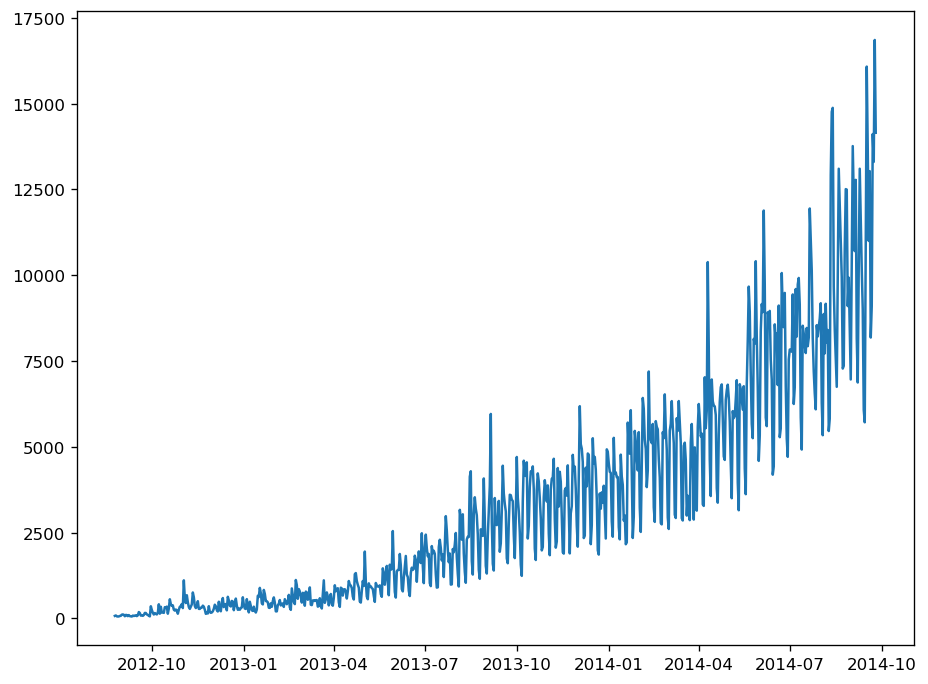

In [2]:
df = pd.read_csv("Train_SU63ISt.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'],format = '%d-%m-%Y %H:%M')
df['date'] = df['Datetime'].dt.date
df = df.groupby(['date'])['Count'].sum().reset_index()
df = df.set_index('date')

plt.plot(df.index, df.Count)

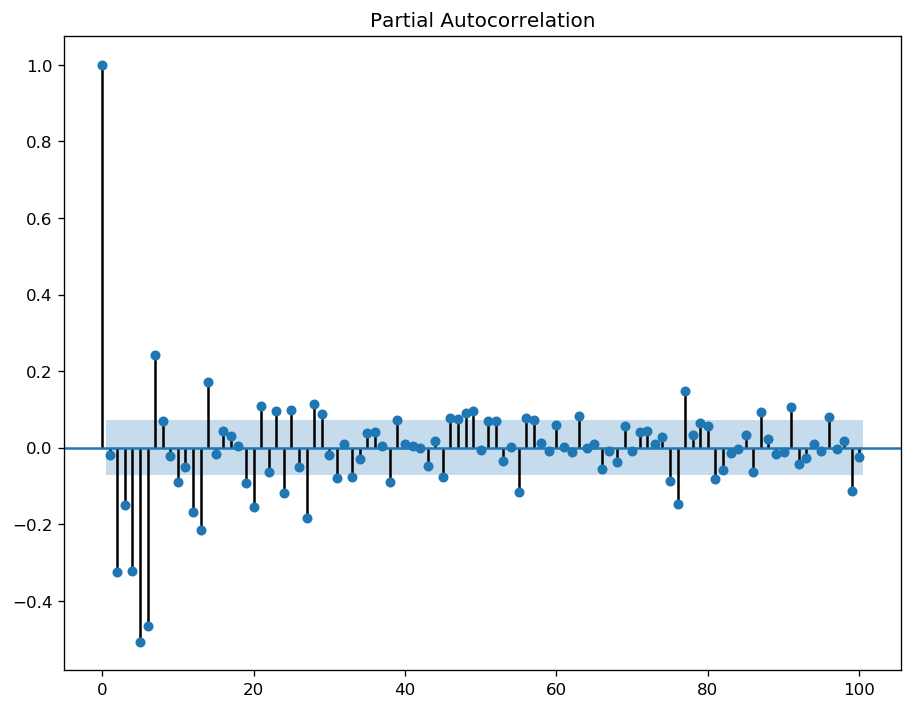

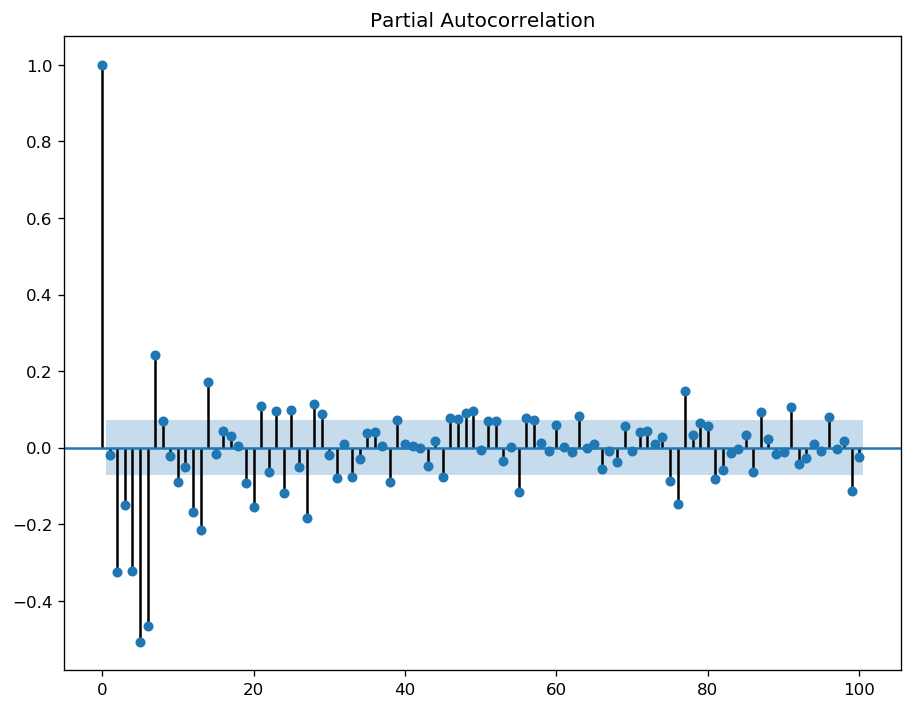

In [3]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plot_pacf(df.Count.diff().dropna(), lags = 100)

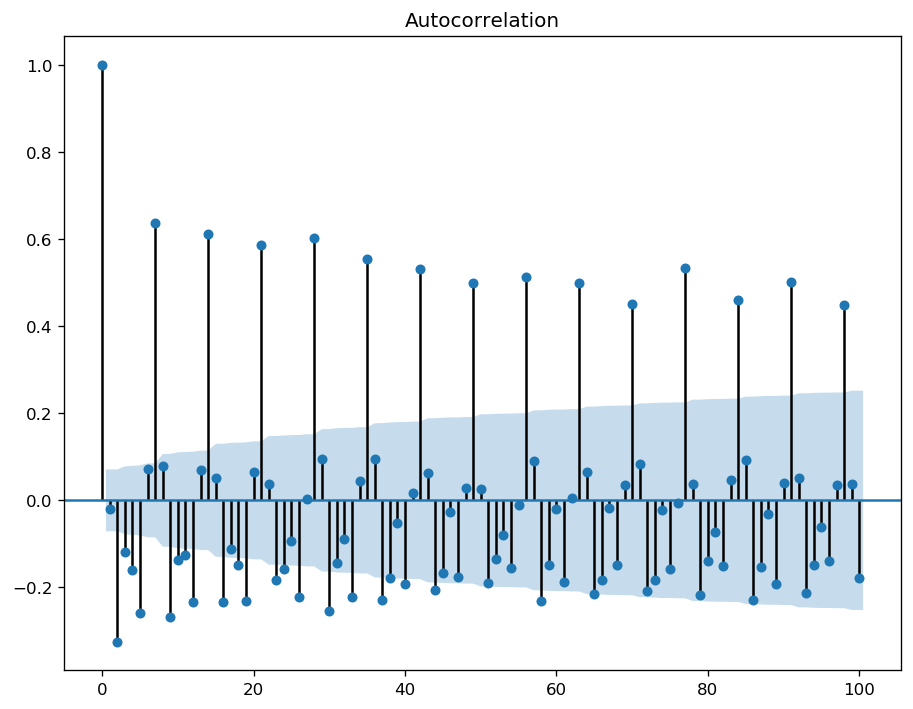

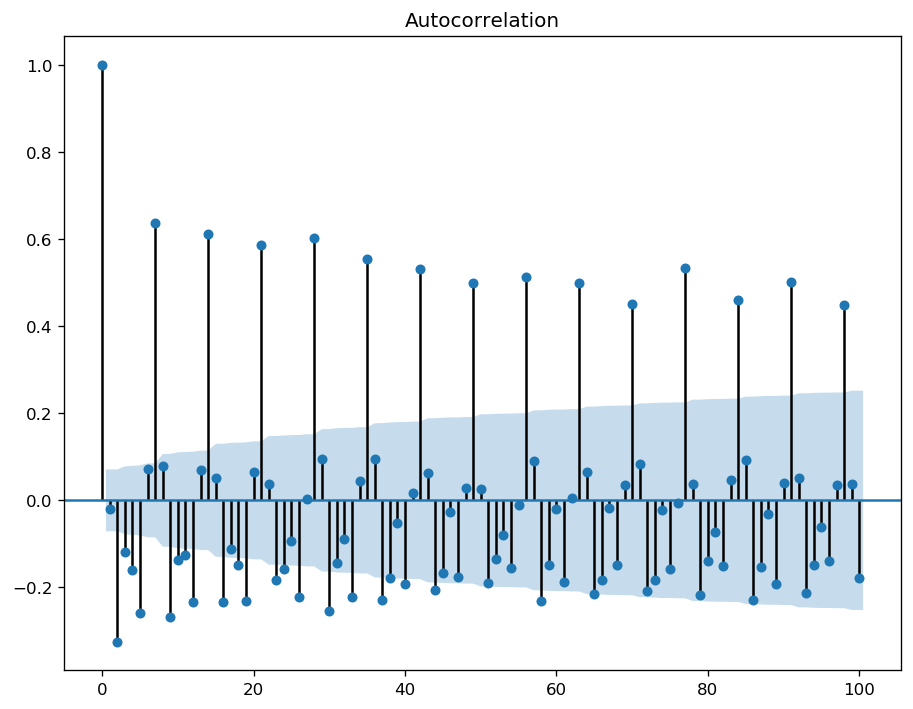

In [4]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plot_acf(df.Count.diff().dropna(), lags = 100)

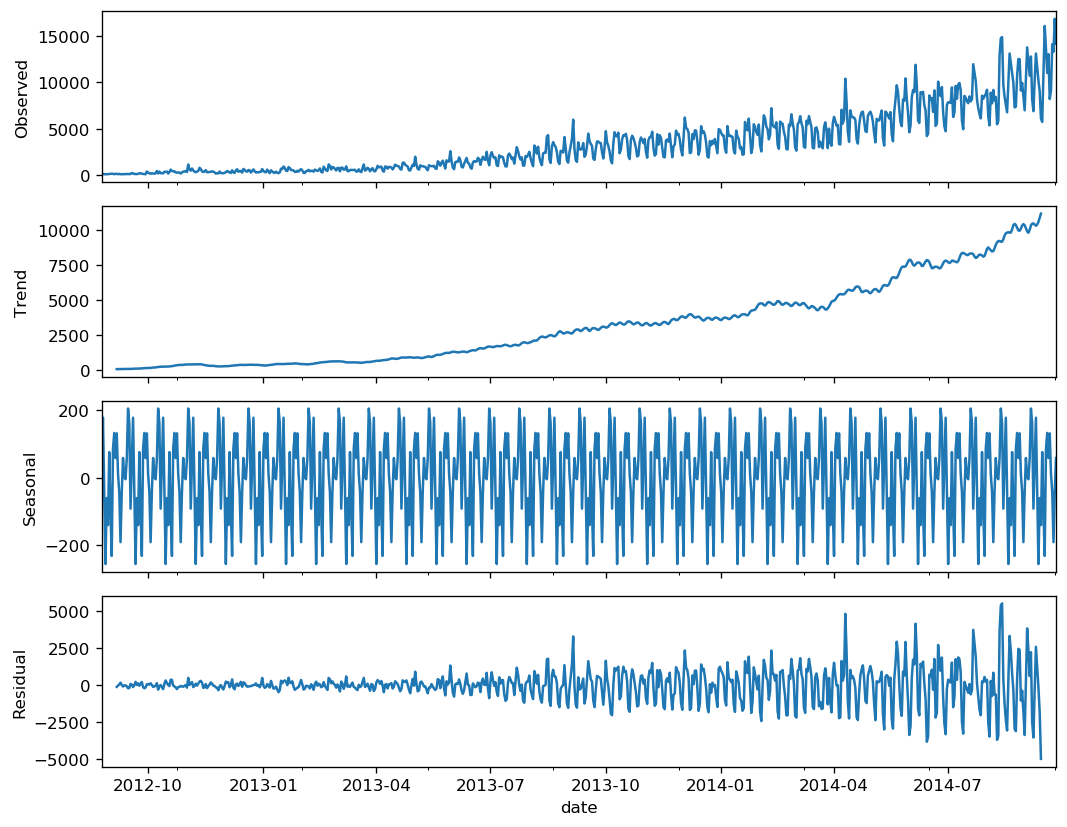

In [5]:
sm.tsa.seasonal_decompose(df.Count, freq=24).plot()
result = sm.tsa.stattools.adfuller(df.Count)
plt.show()

In [7]:
train_df = df[:]

mod = sm.tsa.statespace.SARIMAX(train_df.Count, order=(5,1,2), seasonal_order=(1,1,1,7))
results = mod.fit()
print(results.summary())

a_preds = results.predict(start = 762, end= 974, dynamic= True)
preds_old = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds.sum())

C:\Users\SelvaSaravanakumar\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                             Count   No. Observations:                  762
Model:             SARIMAX(5, 1, 2)x(1, 1, 1, 7)   Log Likelihood               -6073.769
Date:                           Sat, 15 Feb 2020   AIC                          12167.539
Time:                                   15:05:32   BIC                          12213.793
Sample:                               08-25-2012   HQIC                         12185.357
                                    - 09-25-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2430      0.258      0.940      0.347      -0.264       0.750
ar.L2         -0.4894      0.145     -3.365

C:\Users\SelvaSaravanakumar\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


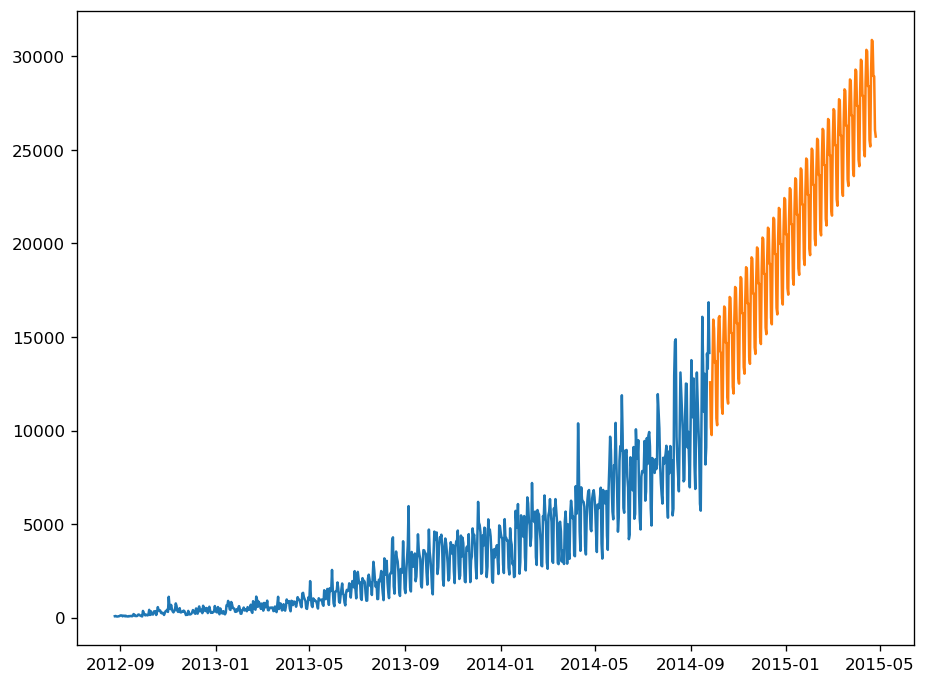

In [8]:
plt.plot(df.index, df.Count)
plt.plot(a_preds.index, a_preds)

In [9]:
er = []
listm = [0.044286588,0.035343014,0.029911076,0.024714453,0.02080223,0.018621427,0.020023091,0.023221497,0.026741002,0.034555218,0.049047207,0.05437526,0.054951351,0.048600186,0.051965438,0.051309072,0.049999488,0.051164262,0.052423477,0.055626605,0.053455246,0.049894816,0.050075828,0.048892166]
for p in range(len(a_preds)):
    for l in range(len(listm)):
        er.append(a_preds[p]*listm[l])
d = {'Count': er}
predf = pd.DataFrame(data=d)
predf.to_csv("submussion_test.csv")

In [10]:
from fbprophet import Prophet

In [11]:
df = pd.read_csv('Train_SU63ISt.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'],format = '%d-%m-%Y %H:%M')
df['date'] = df['Datetime'].dt.date
df = df.groupby(['date'])['Count'].sum().reset_index()
df.columns = ['ds', 'y']
df['y'] = np.log(df['y'])
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=250)
m.fit(df)
future = m.make_future_dataframe(periods=213)
forecast = m.predict(future)

INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


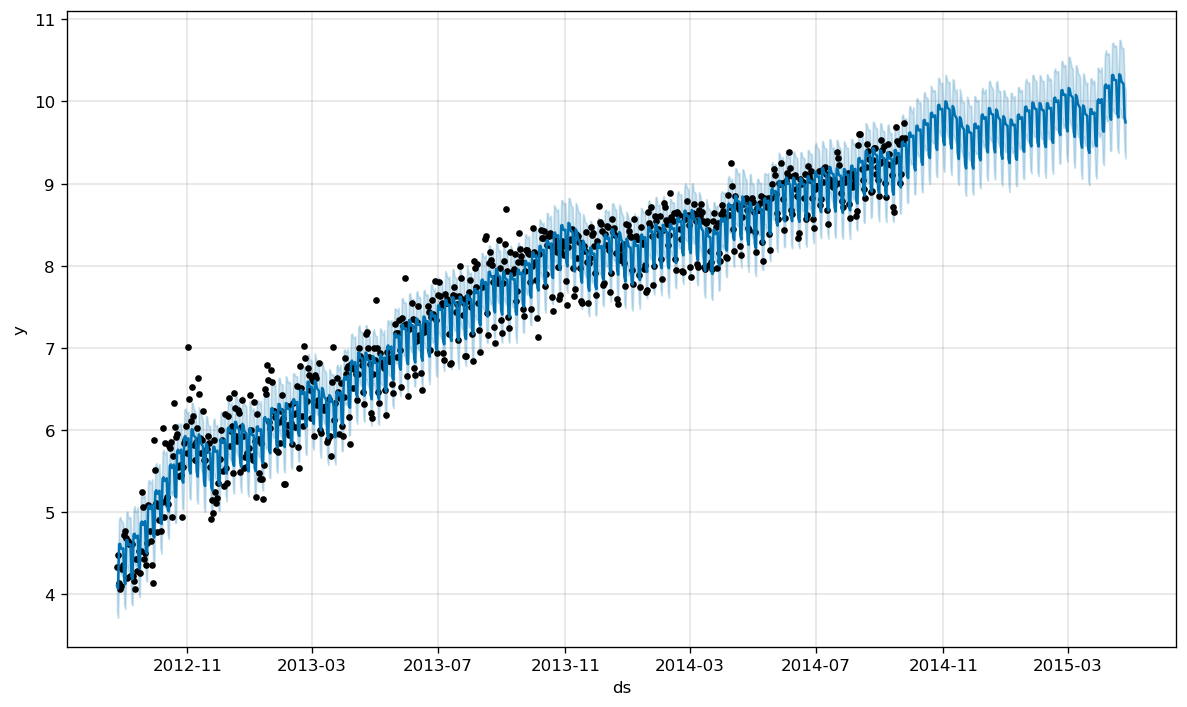

In [12]:
fig1 = m.plot(forecast)

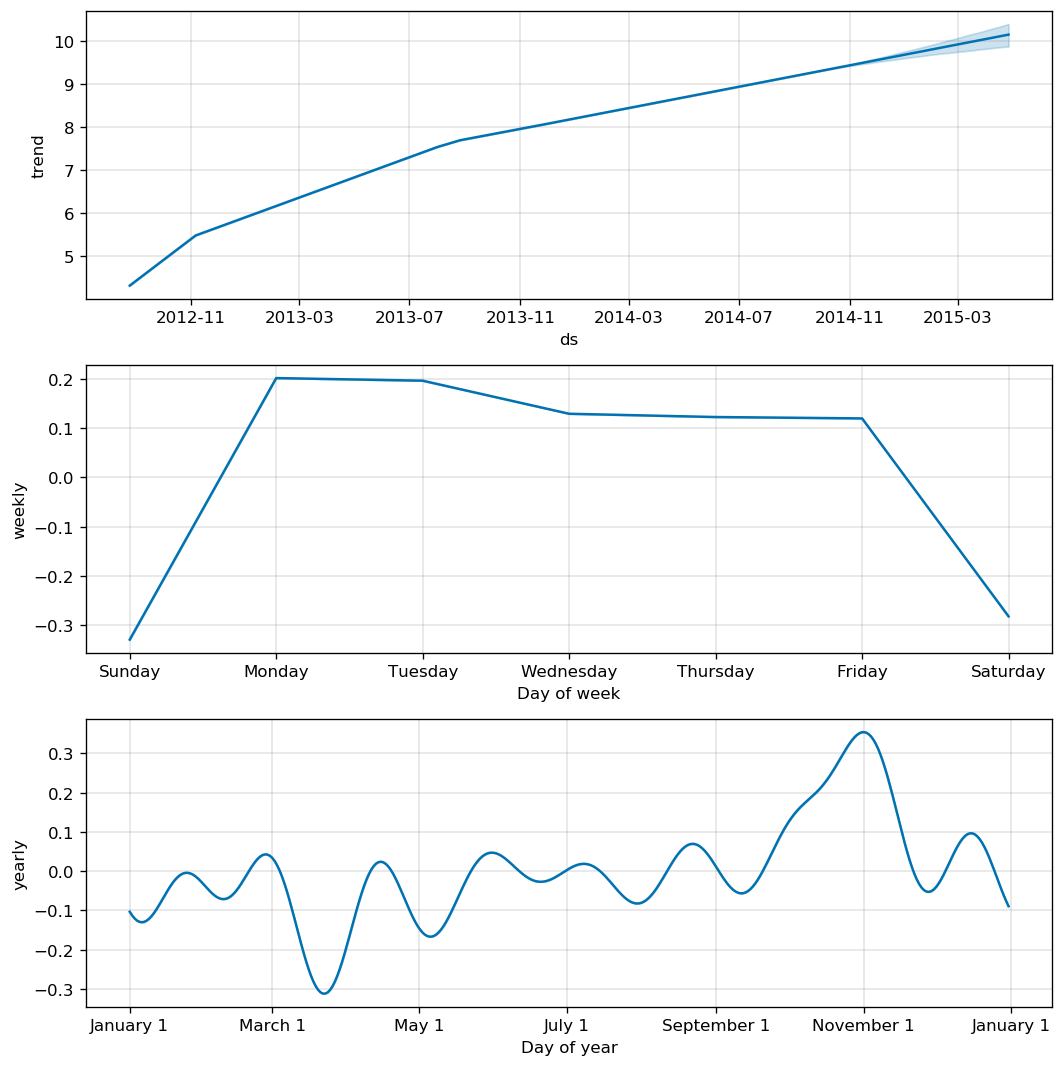

In [13]:
fig2 = m.plot_components(forecast)

In [14]:
f_preds = np.exp(forecast[-213:]['yhat']).values
er = []
listm = [0.044286588,0.035343014,0.029911076,0.024714453,0.02080223,0.018621427,0.020023091,0.023221497,0.026741002,0.034555218,0.049047207,0.05437526,0.054951351,0.048600186,0.051965438,0.051309072,0.049999488,0.051164262,0.052423477,0.055626605,0.053455246,0.049894816,0.050075828,0.048892166]
for p in range(len(f_preds)):
    for l in range(len(listm)):
        er.append(f_preds[p]*listm[l])
d = {'Count': er}
predf = pd.DataFrame(data=d)
predf.to_csv("submussion_test_fb.csv")

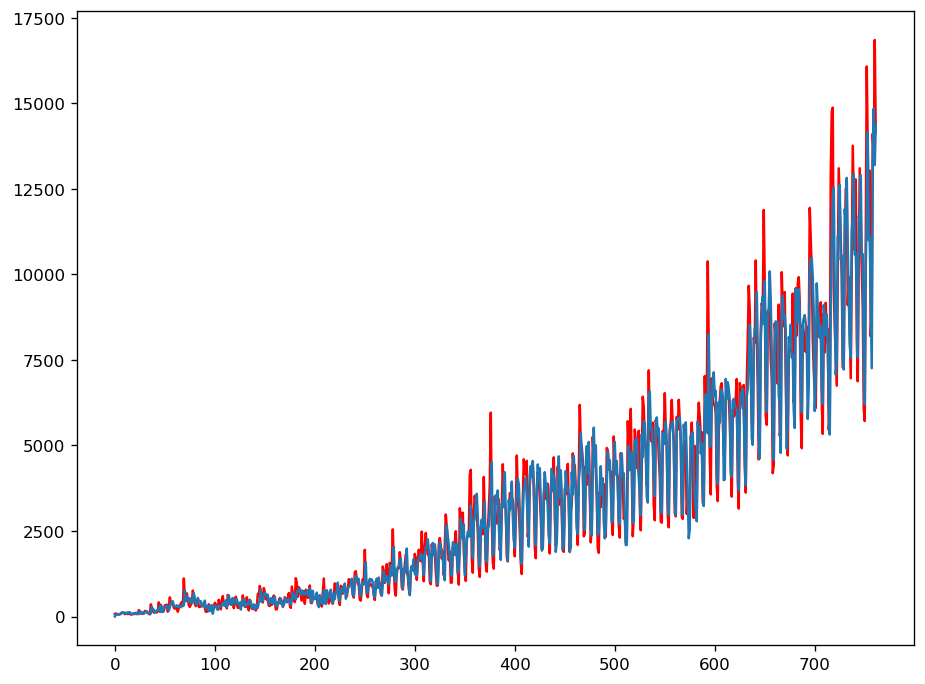

In [15]:
#checking how well the learning happened

preds_old_df = preds_old.reset_index(name="Count")
preds_new_df = a_preds.reset_index(name="Count")
plt.plot(range(0,len(preds_old_df)), train_df.Count,color='red')
plt.plot(range(0,len(preds_old_df)), preds_old_df.Count)

In [24]:
df = pd.read_csv("Train_SU63ISt.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'],format = '%d-%m-%Y %H:%M')
df['date'] = df['Datetime'].dt.date
df = df.groupby(['date'])['Count'].sum().reset_index()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.month
df['day'] = df.date.dt.weekday
df['month_start'] = df.date.apply(lambda x: 1 if x.is_month_start else 0)
df['month_end'] = df.date.apply(lambda x: 1 if x.is_month_end else 0)
df['week_start'] = df.day.apply(lambda x: 1 if x == 0 or x ==1 else 0)
df['week_end'] = df.day.apply(lambda x: 1 if x == 5 or x ==6 else 0)
df['month_day'] = df.date.dt.day
df['predicted'] = preds_old_df.Count
df['diff'] = df.date.apply(lambda x: (x - dateparser.parse('2012-08-25')).days)
df.head()

date  Count  month  day  month_start  month_end  week_start  week_end  \
0 2012-08-25     76      8    5            0          0           0         1   
1 2012-08-26     88      8    6            0          0           0         1   
2 2012-08-27     62      8    0            0          0           1         0   
3 2012-08-28     58      8    1            0          0           1         0   
4 2012-08-29     60      8    2            0          0           0         0   

   month_day  predicted  diff  
0         25   0.000000     0  
1         26  63.507337     1  
2         27  75.154844     2  
3         28  66.687439     3  
4         29  59.969993     4

In [17]:
test_df = pd.read_csv("Test_0qrQsBZ.csv")
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'],format = '%d-%m-%Y %H:%M')
test_df['date'] = test_df['Datetime'].dt.date
test_df = test_df.groupby(['date']).sum().reset_index()
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['month'] = test_df.date.dt.month
test_df['day'] = test_df.date.dt.weekday
test_df['month_start'] = test_df.date.apply(lambda x: 1 if x.is_month_start else 0)
test_df['month_end'] = test_df.date.apply(lambda x: 1 if x.is_month_end else 0)
test_df['week_start'] = test_df.day.apply(lambda x: 1 if x == 0 or x ==1 else 0)
test_df['week_end'] = test_df.day.apply(lambda x: 1 if x == 5 or x ==6 else 0)
test_df['month_day'] = test_df.date.dt.day
test_df['predicted'] = preds_new_df.Count
test_df['diff'] = test_df.date.apply(lambda x: (x - dateparser.parse('2012-08-25')).days)
# test_df['hour'] = test_df.Datetime.dt.hour
test_df.head()

date      ID  month  day  month_start  month_end  week_start  \
0 2014-09-26  439188      9    4            0          0           0   
1 2014-09-27  439764      9    5            0          0           0   
2 2014-09-28  440340      9    6            0          0           0   
3 2014-09-29  440916      9    0            0          0           1   
4 2014-09-30  441492      9    1            0          1           1   

   week_end  month_day     predicted  diff  
0         0         26  12576.254026   762  
1         1         27  10180.952838   763  
2         1         28   9757.520626   764  
3         0         29  13351.928648   765  
4         0         30  15930.386768   766

In [18]:
dfh = df.groupby(['date'])['Count'].sum().reset_index()
dfh.sort_values(['Count'], ascending=[False]).head(50)

date  Count
760 2014-09-24  16856
752 2014-09-16  16080
718 2014-08-13  14878
717 2014-08-12  14762
761 2014-09-25  14152
758 2014-09-22  14116
738 2014-09-02  13764
753 2014-09-17  13676
759 2014-09-23  13304
724 2014-08-19  13104
745 2014-09-09  13104
755 2014-09-19  13034
716 2014-08-11  12928
741 2014-09-05  12780
731 2014-08-26  12510
732 2014-08-27  12496
739 2014-09-03  12216
725 2014-08-20  12022
695 2014-07-21  11946
649 2014-06-05  11886
746 2014-09-10  11592
696 2014-07-22  11012
754 2014-09-18  11000
726 2014-08-21  10952
730 2014-08-25  10764
740 2014-09-04  10704
751 2014-09-15  10688
737 2014-09-01  10464
641 2014-05-28  10410
593 2014-04-10  10384
744 2014-09-08  10224
747 2014-09-11  10180
697 2014-07-23  10130
667 2014-06-23  10066
727 2014-08-22   9944
734 2014-08-29   9930
684 2014-07-10   9922
723 2014-08-18   9912
683 2014-07-09   9732
650 2014-06-06   9730
719 2014-08-14   9672
634 2014-05-21   9670
681 2014-07-07   9600
670 2014-06-26   9486
678 2014-07-04   9442
706 2014-08-01   9186
711 2014-08-06   9170
647 2014-06-03   9162
685 2014-07-11   9148
664 2014-06-20   9118

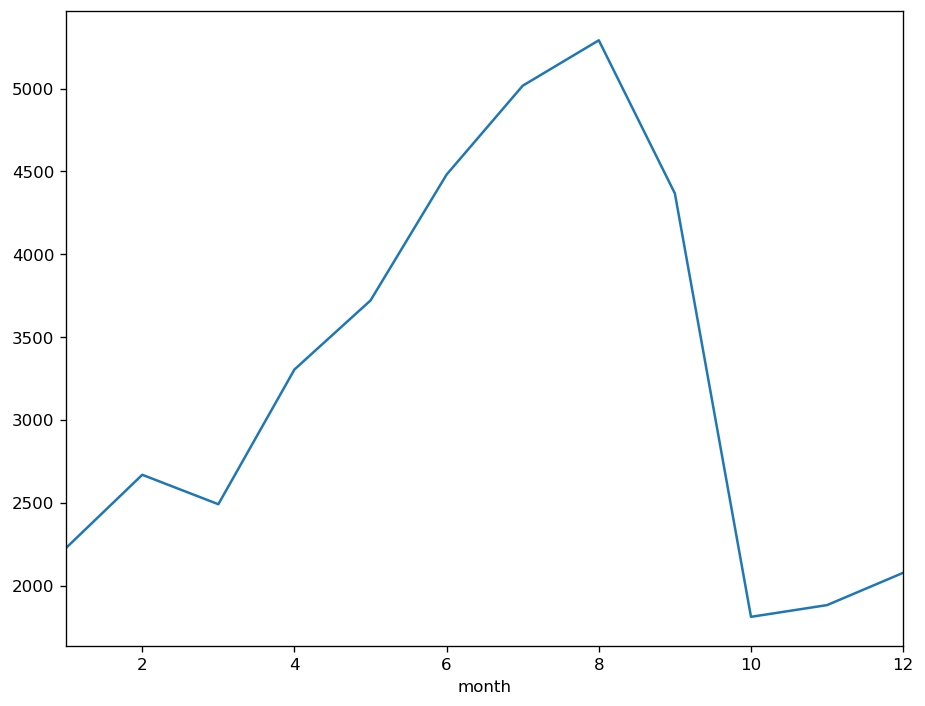

In [19]:
df.groupby(['month'])['Count'].mean().plot()

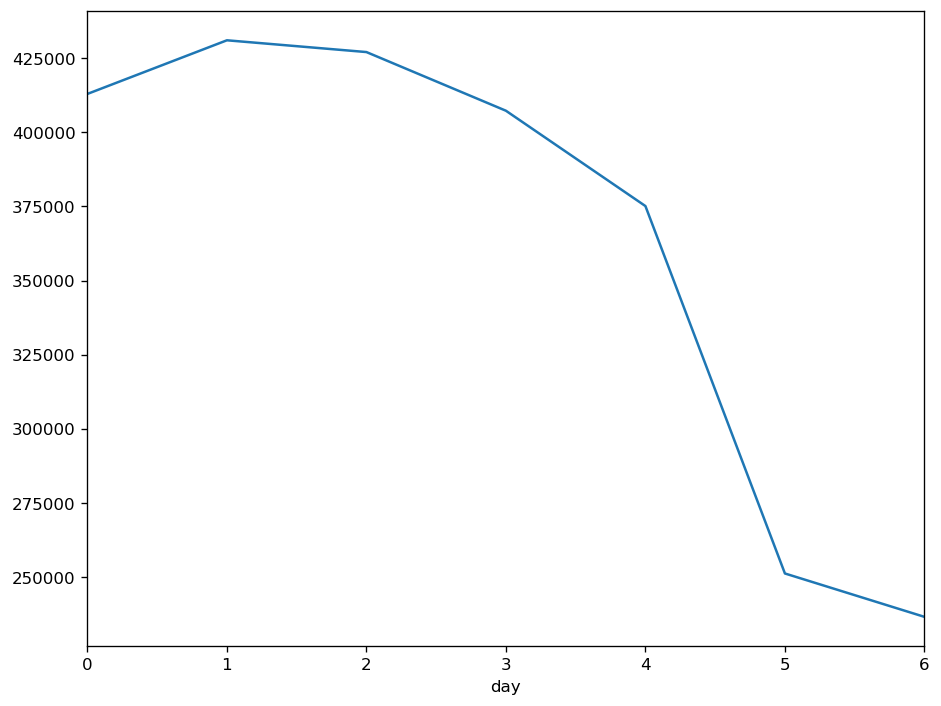

In [20]:
df.groupby(['day'])['Count'].sum().plot()

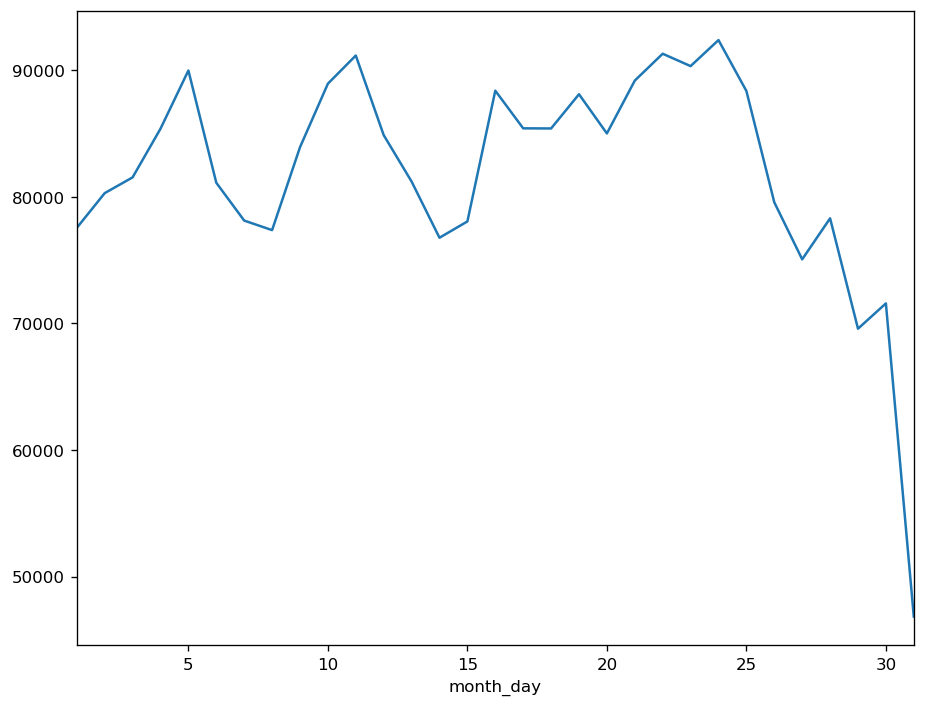

In [21]:
df.groupby(['month_day'])['Count'].sum().plot()

In [25]:
# df.groupby(['hour'])['Count'].sum().plot()

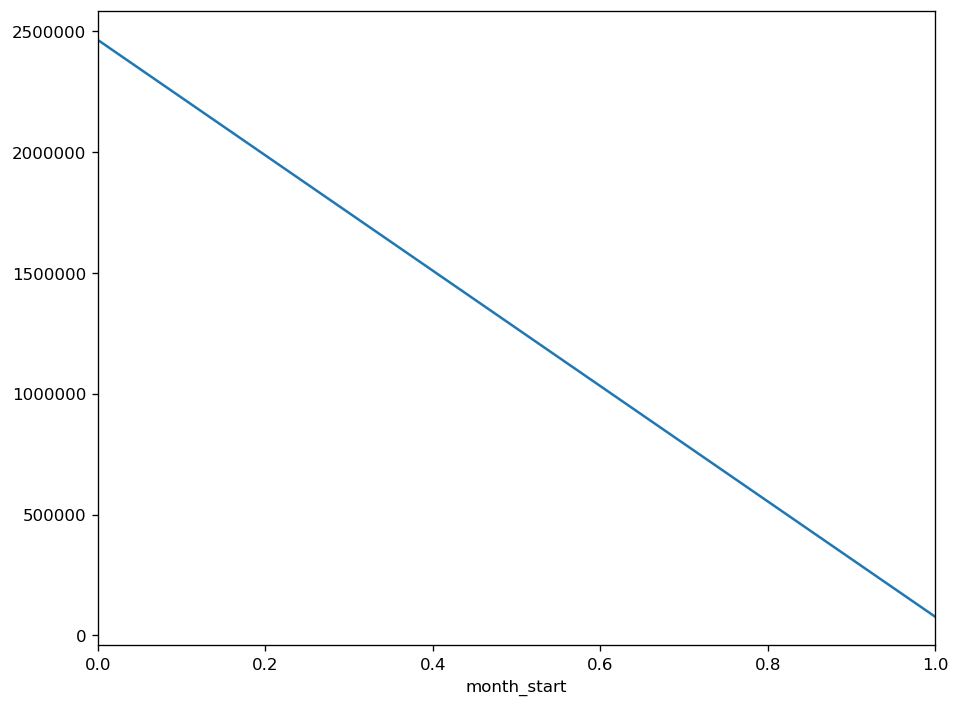

In [26]:
df.groupby(['month_start'])['Count'].sum().plot()

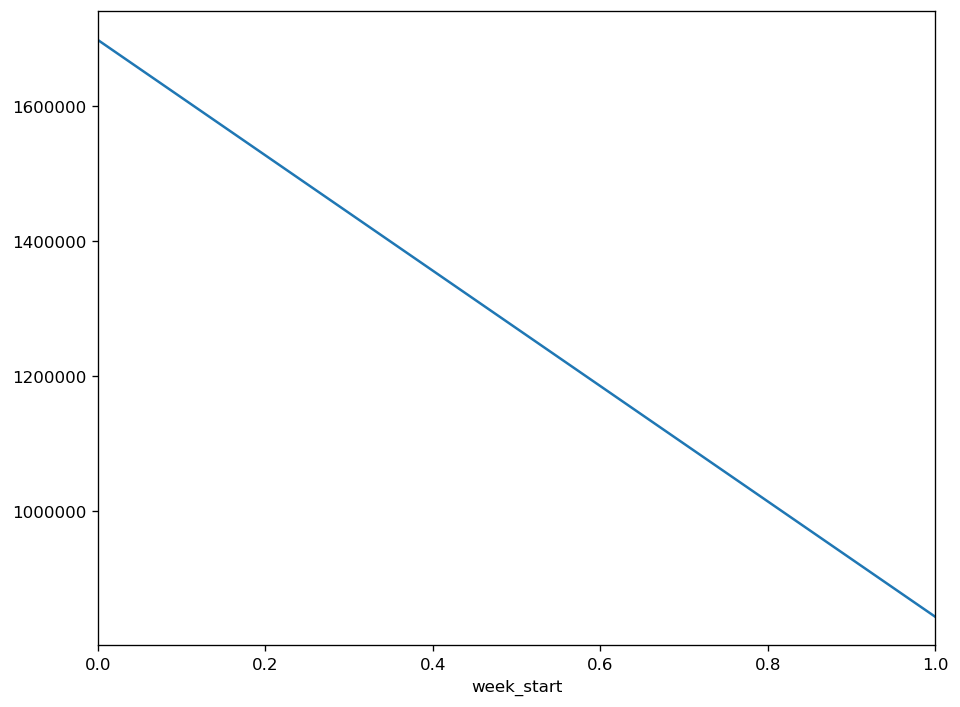

In [27]:
df.groupby(['week_start'])['Count'].sum().plot()

In [28]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = 0#acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [30]:
new_df = df.drop(['date'], axis=1)
new_df.shape

(762, 10)

In [31]:
X_train = new_df[:]#[:700]
y_train = X_train['Count']
dropcols = ['Count']
X_train.drop(dropcols, axis=1,inplace=True)

X_test = new_df[700:]#[710:]
y_test = X_test['Count']
X_test.drop(dropcols, axis=1,inplace=True)

testing_df = test_df.drop(["ID", "date"], axis=1)
testing_df

C:\Users\SelvaSaravanakumar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



month  day  month_start  month_end  week_start  week_end  month_day  \
0        9    4            0          0           0         0         26   
1        9    5            0          0           0         1         27   
2        9    6            0          0           0         1         28   
3        9    0            0          0           1         0         29   
4        9    1            0          1           1         0         30   
..     ...  ...          ...        ...         ...       ...        ...   
208      4    2            0          0           0         0         22   
209      4    3            0          0           0         0         23   
210      4    4            0          0           0         0         24   
211      4    5            0          0           0         1         25   
212      4    6            0          0           0         1         26   

        predicted  diff  
0    12576.254026   762  
1    10180.952838   763  
2     9757.520626   764  
3    13351.928648   765  
4    15930.386768   766  
..            ...   ...  
208  30807.860319   970  
209  28951.872996   971  
210  28935.905869   972  
211  26062.626939   973  
212  25716.297195   974  

[213 rows x 9 columns]

In [32]:
from sklearn import linear_model
linear = linear_model.LinearRegression()
linear.fit(X_train,y_train)

linear1 = linear_model.LinearRegression()
linear1.fit(X_train,np.log(y_train))

rtp = linear.predict(X_test)
rtp1 = np.exp(linear1.predict(X_test))

new_rtp = (rtp + rtp1) / 2

# print(linear.score(X_test, y_test))
# print(forecast_accuracy(np.array(X_test['predicted']), np.array(y_test)))
print(forecast_accuracy(np.array(rtp), np.array(y_test)))
print(forecast_accuracy(np.array(rtp1), np.array(y_test)))
# print(forecast_accuracy(np.array(np.exp(rtp)), np.array(np.exp(y_test))))

for c,cc in enumerate(linear.coef_):
    print(X_train.columns[c])
    print(cc)


{'mape': 0.10749425374484015, 'me': -147.7831932864218, 'mae': 1111.139691170464, 'mpe': 0.005755994370455458, 'rmse': 1474.9379788330425, 'acf1': 0, 'corr': 0.8564716144694194, 'minmax': 0.10080365475302944}
{'mape': 0.3029237505875354, 'me': 1348.7748053677165, 'mae': 2671.3650196296917, 'mpe': 0.20827856941557157, 'rmse': 3096.3862516117506, 'acf1': 0, 'corr': 0.34669773655533503, 'minmax': 0.22101988622759716}
month
5.73072310983958
day
-11.091826528718043
month_start
43.873699474288124
month_end
-34.244539904603826
week_start
80.13778451563527
week_end
-150.0892969454659
month_day
-1.805119379877224
predicted
0.9568041726358733
diff
0.6503282889556904


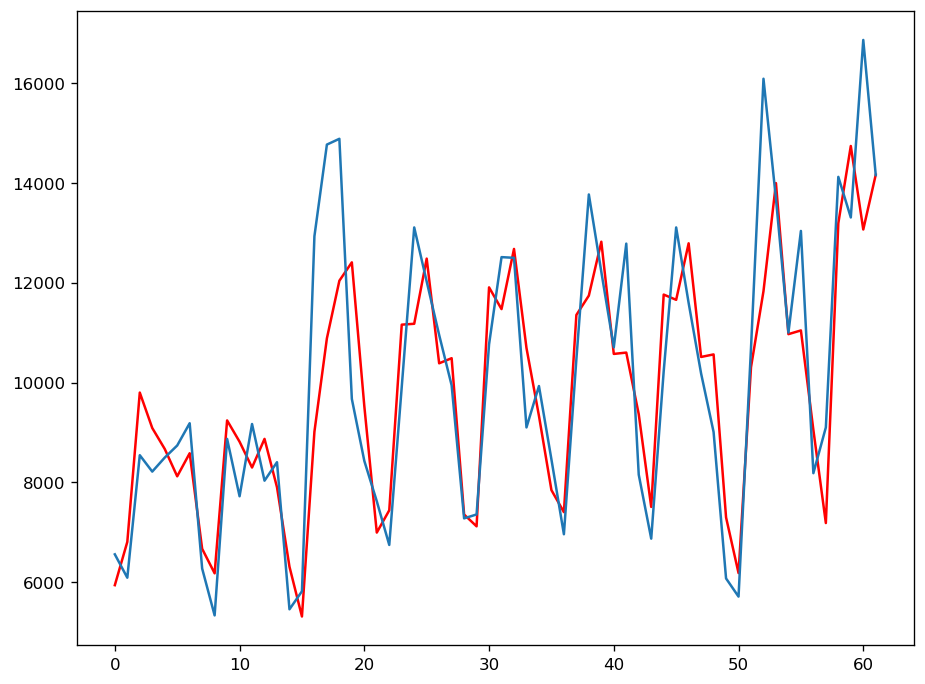

In [33]:
plt.plot(range(0,len(rtp)), rtp,color='red')
plt.plot(range(0,len(rtp)), y_test)

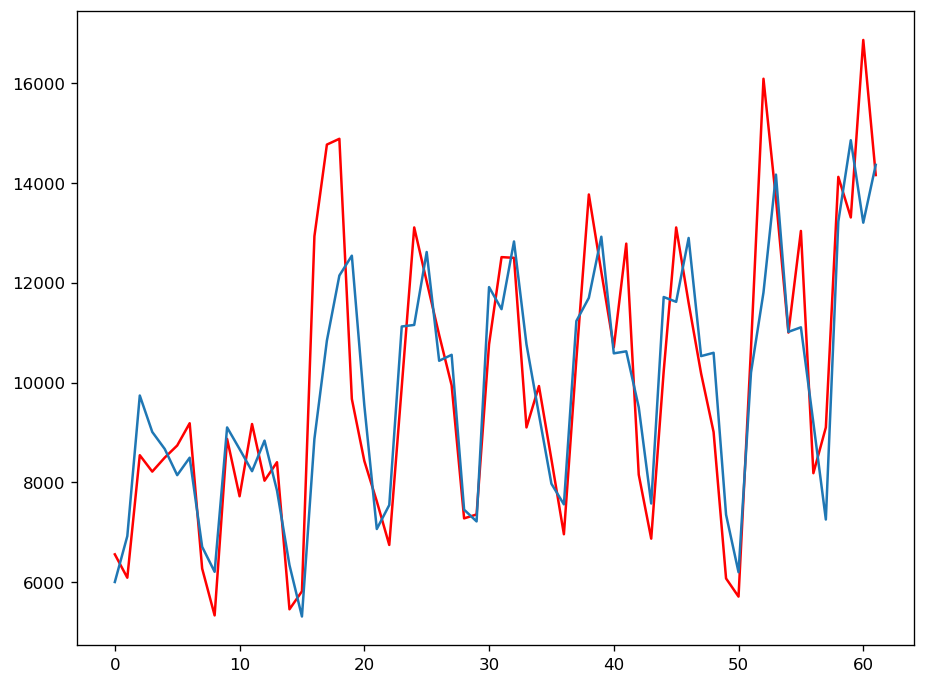

In [34]:
plt.plot(range(0,len(preds_old_df[700:])), train_df[700:].Count,color='red')
plt.plot(range(0,len(preds_old_df[700:])), preds_old_df[700:].Count)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


rf = RandomForestRegressor(random_state = 42)
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [36]:
rf_model = RandomForestRegressor(**rf_random.best_params_)
rf_model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [37]:
rtp = rf_model.predict(X_test)
print(forecast_accuracy(np.array(rtp), np.array(y_test)))

{'mape': 0.07100792788301277, 'me': 10.093892777925527, 'mae': 728.8396445479955, 'mpe': 0.013585480113051161, 'rmse': 994.575357794161, 'acf1': 0, 'corr': 0.9385644344139545, 'minmax': 0.06677438557907878}


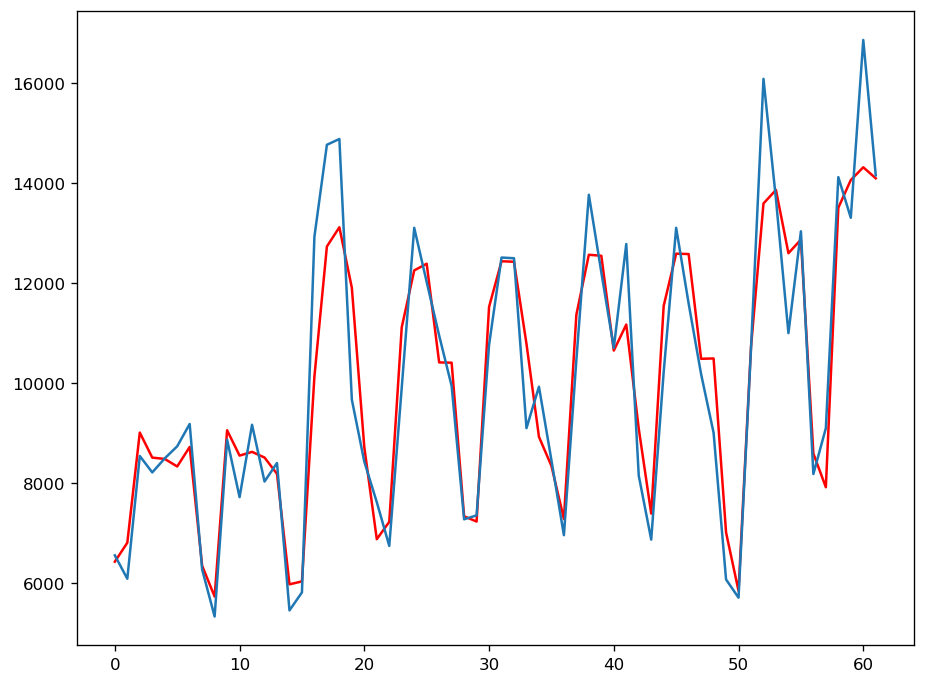

In [38]:
plt.plot(range(0,len(rtp)), rtp,color='red')
plt.plot(range(0,len(rtp)), y_test)

In [39]:
linear_pred = linear.predict(testing_df)

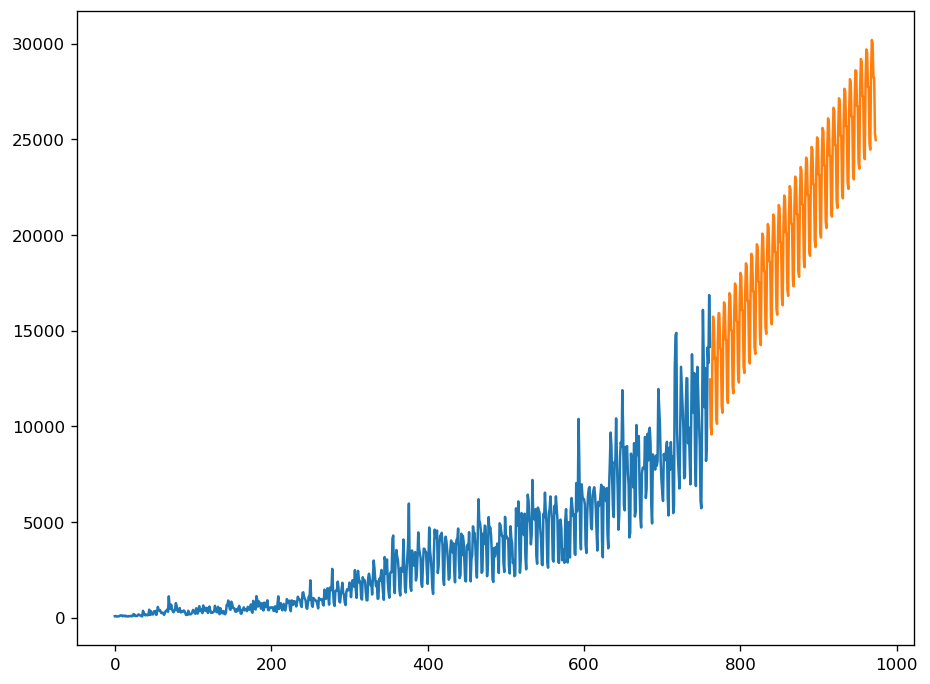

In [40]:
plt.plot(df.index, df.Count)
plt.plot(testing_df.index+761, linear_pred)

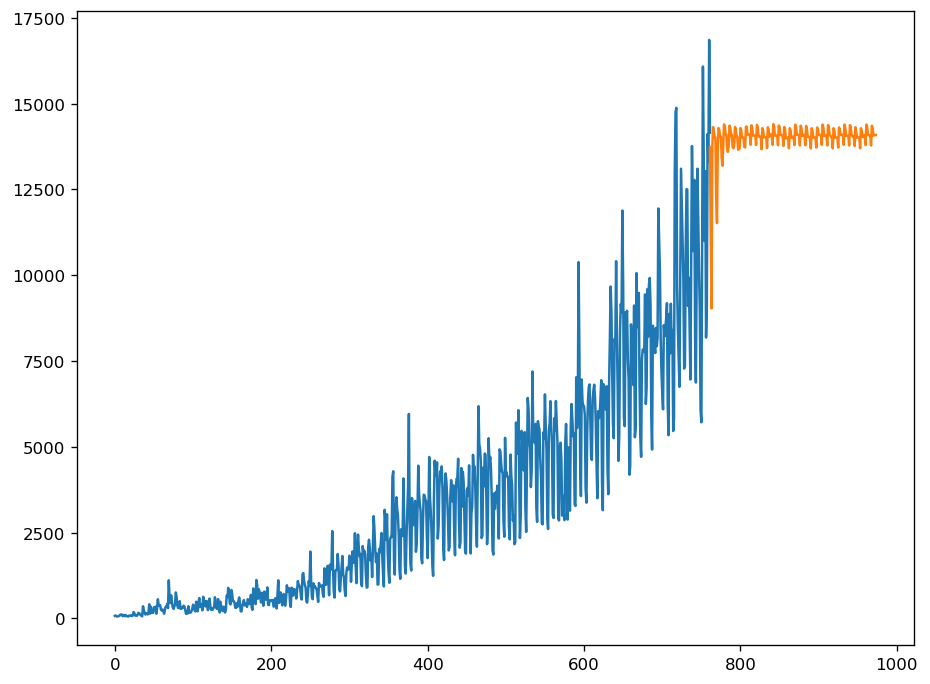

In [44]:
rf_test_pred = rf_model.predict(testing_df)
plt.plot(df.index, df.Count)
plt.plot(testing_df.index+761, rf_test_pred)

In [45]:
rf_test_pred.sum()

2983092.9947726233

In [41]:
ensemble_preds = (a_preds + f_preds + linear_pred) / 3

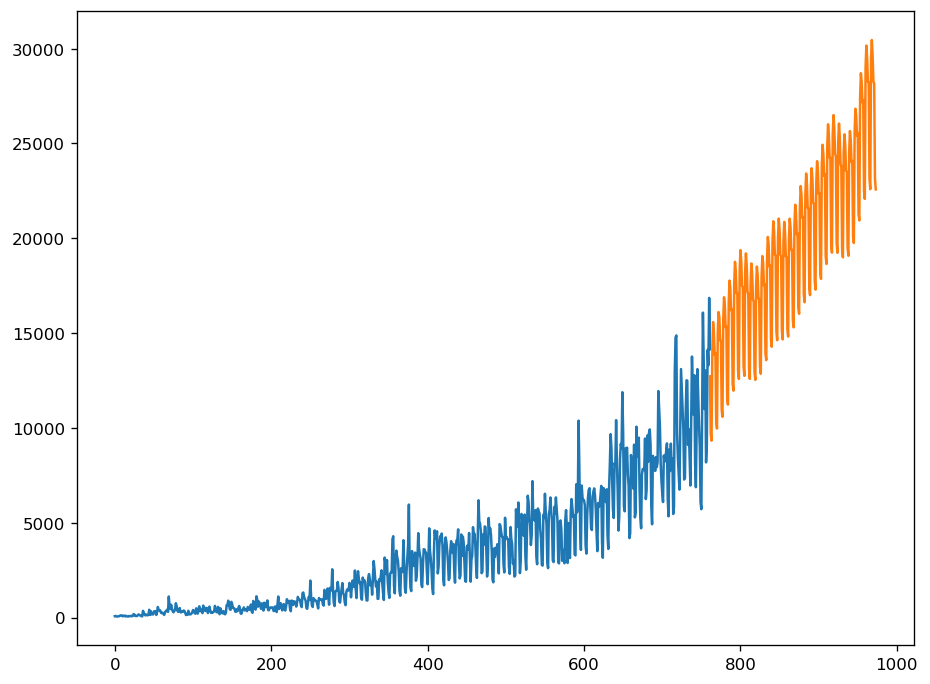

In [42]:
plt.plot(X_train.index, y_train)
plt.plot(testing_df.index+761, ensemble_preds)

In [43]:
er = []
listm = [0.044286588,0.035343014,0.029911076,0.024714453,0.02080223,0.018621427,0.020023091,0.023221497,0.026741002,0.034555218,0.049047207,0.05437526,0.054951351,0.048600186,0.051965438,0.051309072,0.049999488,0.051164262,0.052423477,0.055626605,0.053455246,0.049894816,0.050075828,0.048892166]
for p in range(len(ensemble_preds)):
    for l in range(len(listm)):
        er.append(ensemble_preds[p]*listm[l])
d = {'Count': er}
predf = pd.DataFrame(data=d)
predf.to_csv("submussion_test.csv")